In [49]:
from typing import Callable

from sklearn import datasets

import checker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import utils


## Wstęp do PyTorcha
* PyTorch to biblioteka do uczenia maszynowego, w szczególności głębokiego.

**Interfejs** jest bardzo podobny do numpy, z wyjątkiem pewnych zmian:
* Zamiast `numpy.ndarray` naszym podstawowym obiektem będzie teraz `torch.Tensor`. Tensor, czyli uogólnienie macierzy do wyższych wymiarów.
* Jeśli chcemy zsumować macierz `A` po pierwszym wymiarze, w numpy zrobilibyśmy `A.sum(axis=0)`. W PyTorch zamiast tego używamy argumentu `dim`: `A.sum(dim=0)`.
* Zamiast `np.concatenate` jest `torch.cat`.
* Zamiast `np.power` jest `torch.pow`.
* I tym podobne.

W nowszych wersjach PyTorcha [pojawia się coraz więcej podobieństw do NumPy](https://github.com/pytorch/pytorch/issues/38349), co pozwala m. in. używać argumentu `axis` wymiennie z `dim`. Przy przechodzeniu między tymi dwiema bibliotekami warto jednak uważać, gdyż nie wszystkie metody zachowują się w identyczny sposób.



Przejście z `numpy.ndarray` do `torch.Tensor` (i na odwrót) jest bardzo proste:
* `A (numpy.ndarray) -> B (torch.Tensor)`: `B = torch.from_numpy(A)`
* `B (torch.Tensor) -> A (numpy.ndarray)`: `A = B.numpy()`
    
Kluczowe różnice:
* PyTorch **automatycznie liczy dla nas gradienty**. Nie musimy własnoręcznie liczyć na kartce wzoru na gradient a potem przepisywać go do programu.
* PyTorch ma **wsparcie dla GPU**, co umożliwia szybkie obliczenia w sieciach neuronowych.

Dobre materiały do nauki PyTorcha: [Deep Learning in 60 minutes](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), [PyTorch Examples](https://github.com/pytorch/examples).

Drobna uwaga - te tutoriale opisują abstrakcje takie jak `torch.nn.Module`, `torch.optim.SGD` czy `torch.utils.data`, którymi będziemy się zajmować od kolejnych zajęć. Na tych zajęciach spróbujemy zobaczyć, co PyTorch robi "pod spodem".

## Automatyczne różniczkowanie w PyTorchu

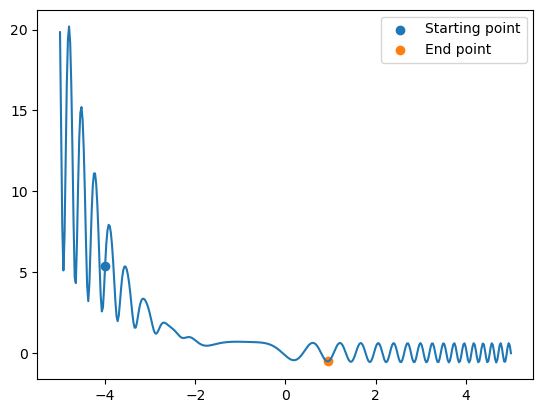

In [10]:
def gradient_descent(
    loss: Callable[[torch.Tensor, torch.Tensor, torch.Tensor | None], torch.Tensor],
    X: torch.Tensor,
    parameters: torch.Tensor,
    y: torch.Tensor | None = None,
    lr: float = 1e-6,
    num_steps: int = int(1e4),
) -> torch.Tensor:
    for idx in range(num_steps):
        # Informujemy PyTorcha, że chcemy dostać gradient po naszych parametrach
        parameters.requires_grad = True

        # Liczymy wartość funkcji kosztu.
        loss_val = loss(X, parameters, y)

        # Każemy PyTorchowi policzyć gradient
        loss_val.backward()

        # Wyciągamy gradient po parametrach
        gradient = parameters.grad

        # Wykonujemy krok metody spadku gradientu
        with torch.no_grad():
            parameters = parameters - lr * gradient

    # Zwracamy najlepsze parametry
    return parameters


# Dziwna funkcja, której minimum będziemy chcieli znaleźć.
def complex_fn(a: torch.Tensor, x: torch.Tensor, _: torch.Tensor | None = None) -> torch.Tensor:
    y = a[0] / a[1] * torch.cos(a[0] * x**2 + a[1] * x - a[2])
    z = torch.exp(-x) / (y + 3)
    return -(z + y) + torch.exp(-x - 0.8)


a = torch.tensor([3.0, 5.0, 1.0])
x = torch.tensor(-4.0)
result = gradient_descent(complex_fn, a, x, lr=2e-2, num_steps=int(2e4))

utils.plot_torch_fn(complex_fn, a, x, result)

In [11]:
# Preparing datasets
torch.manual_seed(5)

# Regression dataset
diabetes = datasets.load_diabetes()
diabetes_X = torch.tensor(diabetes.data, dtype=torch.float32)
diabetes_y = torch.tensor(diabetes.target, dtype=torch.float32)
diabetes_w = torch.randn(diabetes_X.shape[1], dtype=torch.float32, requires_grad=True)

diabetes_data = (diabetes_X, diabetes_y, diabetes_w)


# Multidimensional datasets
dataset_5d = torch.randn([1000, 5], dtype=torch.float32)
param_5d = torch.randn(5, requires_grad=True)

dataset_20d = torch.randn([325, 20], dtype=torch.float32)
param_20d = torch.randn(20, requires_grad=True)

multi_datasets = [(dataset_5d, param_5d), (dataset_20d, param_20d)]

## Zadanie 1 (2 pkt.)

Zaimplementuj w PyTorchu funkcje kosztu, które minimalizowaliśmy na wcześniejszych ćwiczeniach. Czyli konkretnie:
* `mean_squared_error` (lab 02)
* `mean_error` (lab 02)
* `max_error` (lab 02)
* `linear_regression_loss` (lab 03)
* `regularized_regression_loss` (lab 03)

Proszę te funkcje przekleić (ze swoich rozwiązań czy też oficjalnych) i przerobić tak, żeby przyjmowały `torch.Tensor` zamiast `np.ndarray` oraz zwracały `torch.Tensor`.

In [13]:
def mean_squared_error(X: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    distances_sq = torch.norm(X - theta, dim=1) ** 2  # (N,)
    return torch.mean(distances_sq)
checker.check_4_1_mse(mean_squared_error, multi_datasets)

In [18]:
def mean_error(X: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    distances = torch.norm(X - theta, dim=1)
    return torch.mean(distances)

checker.check_4_1_me(mean_error, multi_datasets)

In [20]:
def max_error(X: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    distances = torch.norm(X - theta, dim=1)
    return torch.max(distances)


checker.check_4_1_max(max_error, multi_datasets)

In [26]:
def linear_regression_loss(X: torch.Tensor, w: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    y_pred = X @ w
    return torch.mean((y_pred - y) ** 2)


checker.check_4_1_lin_reg(linear_regression_loss, diabetes_data)

In [28]:
def regularized_regression_loss(X: torch.Tensor, w: torch.Tensor, y: torch.Tensor, alpha: float = 0.2) -> torch.Tensor:
    y_pred = X @ w #res out*weight
    mse = torch.mean((y_pred - y) ** 2 ) # pred - res
    reg = alpha * torch.sum(w ** 2)
    return mse + reg 


checker.check_4_1_reg_reg(regularized_regression_loss, diabetes_data)

# Część 1: Regresja logistyczna

## Klasyfikacja

Dzisiaj na zajęciach zajmiemy się problemem klasyfikacji. Podobnie do regresji liniowej jest to przykład uczenia nadzorowanego, ale zamiast przewidywać konkretną liczbę dla danej obserwacji, przewidujemy jego przynajeżność do jednej z *k* klas. Na tych zajęciach będziemy rozważać klasyfikacje binarną, czyli uczyć modele odpowiadające funkcji:

$$ f(x) = y, \quad y \in \{0,1\} $$

## Modele probabilistyczne i decyzyjne
Przyjmujemy, że mamy zadanie klasyfikacji binarnej (dwie klasy). Na wykładzie poznaliśmy co najmniej dwie metody klasyfikacji:

1. Support Vector Machine, który dla zadanego przykładu podaje nam po prostu jego przewidzianą klasę $y$
2. Regresję logistyczną, która zwraca rozkład na klasach.

SVM tym samym nie jest jednak w stanie powiedzieć nam jak bardzo pewny jest swojej decyzji, regresja logistyczna potrafi to osiągnąć. Na tej podstawie możemy stworzyć sobie następujący podział modeli klasyfikacyjnych:

* **Modele decyzyjne** - są w stanie odpowiedzieć nam, jaki jest najbardziej prawdopodobna etykieta $y$ dla przykładu $x$, ale nie dają rozkładu prawdopodobieństwa.
* **Modele probabilistyczne** - zadają nam rozkład na etykietach $p(y \mid x)$, dzięki czemu dostajemy więcej informacji.

**Pytanie:** Dlaczego może nas interesować cały rozkład prawdopodobieństwa zamiast najbardziej prawdopodobnej odpowiedzi?

## Regresja logistyczna jako model probabilistyczny
Chcielibyśmy stworzyć model, który otrzymując na wejściu $x$ będzie w stanie nam powiedzieć, jakie jest prawdopodobieństwo, że $y = 0$. Tzn, jeśli nasz model to funkcja $g(x)$, to nasza funkcja ma zadawać rozkład prawdopodobieństwa:

$$g(x) = \hat{p}(y = 1 \mid x)$$

Z tego możemy łatwo wyciągnąć prawdopodobieństwo, że zadany przykład ma etykietę $0$, tzn:
$$ \hat{p}(y = 0 \mid x) = 1 - \hat{p}(y = 1 \mid x) = 1 - g(x) $$


**Pytanie:** Kiedy będziemy mieli model zadający nam rozkład $\hat{p}(y \mid x)$, jak odpowiedzieć na pytanie "jaka jest etykieta zadanego przykładu"?

## Regresja logistyczna na podstawie regresji liniowej

**Problem:** Jak uzyskać probabilistyczny model klasyfikacyjny? Moglibyśmy użyć naszego modelu liniowego o postaci $f(x) = w^Tx + b$, ale ten model ma wadę: może przewidywać dowolne wartości ze zbioru liczb rzeczywistych, tzn. $f(x) \in \mathbb{R}$, natomiast z definicji prawdopodobieństwo $p(y=1) \in [0, 1]$.

*Uwaga: Wcześniej nasz model liniowy był postaci $f(x) = w^Tx$, teraz dodaliśmy jeszcze tzw. bias $b \in \mathbb{R}$, który pozwala nam reprezentować przekształcenia afiniczne, a nie tylko liniowe.* 

**Rozwiązanie:** Potrzebujemy więc funkcji, która "spłaszczy" nam przedział $\mathbb{R}$ do $[0, 1]$. Można by taką funkcję znaleźć na wiele sposobów, ale z powodów technicznych najczęściej korzysta się z sigmoidy, tzn.:
$$ \sigma(x) = \frac{1}{1 + \exp(-x)} $$

**Wykres funkcji sigmoid**

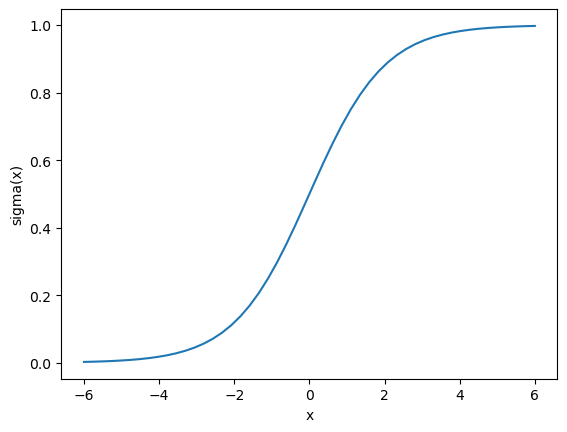

In [30]:
plt.xlabel("x")
plt.ylabel("sigma(x)")

X = np.linspace(-6, 6)
plt.plot(X, 1 / (1 + np.exp(-X)))
plt.show()

Ostatecznie nasz model wygląda tak:
$$
    \hat{p}(y = 1 \mid x) = \sigma(w^Tx + b)
$$

Mamy więc model, który jest w stanie dać nam rozkład prawdopodobieństwa etykiety pod warunkiem $\hat{p}(y \mid x)$. Nasz zbiór treningowy zawiera też próbki z prawdziwego rozkładu prawdopodobieństwa: $p(y_i \mid x_i)$.

Jako funkcję kosztu wybieramy sobie więc "różnicę" pomiędzy prawdziwym rozkładem, a rozkładem zadanym przez nasz model. W tym wypadku sprawdza się **entropia krzyżowa** (cross-entropy), zadana wzorem:


\begin{split}
      \mathcal{H}(p(y \mid x_i), \hat{p}(y \mid x_i)) &= -\sum_{k \in \{0, 1\}} p(y=k \mid x_i) \ln \hat{p}(y=k \mid x_i) \\
      &= -p(y = 0 \mid x_i) \ln \hat{p}(y = 0 \mid x_i) - p(y=1 \mid x_i) \ln \hat{p}(y=1 \mid x_i) \\
      &= -(1 - p(y = 1 \mid x_i)) \ln (1 - \hat{p}(y = 1 \mid x_i)) - p(y=1 \mid x_i) \ln \hat{p}(y=1 \mid x_i) \\
      &= - (1 - y_i) \ln (1 - \hat{y}) - y_i \ln \hat{y} ,
\end{split}
gdzie podstawiliśmy sobie: $$\hat{p}(y=1 \mid x_i) = \hat{y}, \\ p(y=1 \mid x_i) = y_i$$

Ustalmy teraz, że ostateczną funkcją kosztu naszego modelu będzie średnia entropia krzyżowa dla zbioru danych:
$$
    \mathcal{L}(X) = \frac{1}{N} \sum_{(x_i, y_i) \in X}^N  \mathcal{H}(p(y \mid x_i), \hat{p}(y \mid x_i))
$$


Taki model możemy teraz optymalizować metodą spadku gradientu i wykorzystać do klasyfikacji.

In [32]:
# Przygotujmy datasety i funkcje pomocnicze
dataset_1d = utils.get_classification_dataset_1d()
dataset_2d = utils.get_classification_dataset_2d()


def calculate_accuracy(
    logistic_reg: "LogisticRegression", X: torch.Tensor, y: torch.Tensor
) -> float:
    preds = logistic_reg.predict(X)
    correct_n = (preds == y).float().sum().item()
    return float(correct_n / len(y))


def plot_dataset_1d(logistic_reg: "LogisticRegression", dataset_1d: utils.Dataset) -> None:
    plt.scatter(dataset_1d.data[:10], [0.5] * 10, c="purple", label="0")
    plt.scatter(dataset_1d.data[10:], [0.5] * 10, c="yellow", label="1")
    linspace = torch.linspace(-7.5, 15, steps=100).view(-1, 1)
    plt.plot(
        linspace.numpy().ravel(),
        logistic_reg.predict_proba(linspace).detach().numpy(),
        label="p(y=1 | x)",
    )
    plt.legend()
    plt.show()


def plot_dataset_2d(logistic_reg: "LogisticRegression", dataset_2d: utils.Dataset) -> None:
    plt.scatter(dataset_2d.data[:50, 0], dataset_2d.data[:50, 1], c="purple", label="0")
    plt.scatter(dataset_2d.data[50:, 0], dataset_2d.data[50:, 1], c="yellow", label="1")

    linspace_x = torch.linspace(-4, 7, steps=100)
    linspace_y = (-logistic_reg.bias - logistic_reg.weight[0] * linspace_x) / logistic_reg.weight[1]

    linspace_y = linspace_y.detach().numpy()
    plt.plot(linspace_x.detach().numpy(), linspace_y, label="Granica decyzyjna")
    plt.legend()

## Zadanie 2 (2 pkt.)

Zaimplementuj w PyTorchu regresję logistyczną. W tym celu trzeba napisać następujące funkcje:
1. Funkcję kosztu modelu regresji logistycznej `loss(X, y)`, według następujących kroków:
    * Policz model liniowy $z = w^Tx + b$
    * Na wektorze $z$ zaimplementuj funkcję $\hat{y} = \sigma(z) = \frac{1}{1 + \exp(-z)}$.
    * Policz entropię krzyżową pomiędzy predykcjami $\hat{y}$ a etykietami $y$ zadaną przez:
    $\frac{1}{N} \sum_i - (1 - y_i) \ln (1 - \hat{y}_i) - y_i \ln \hat{y}_i$
2. Funkcję `predict_proba(X)` zwracającą dla każdego $x_i \in X$ zadane przez nasz model prawdopodobieństwo $\hat{p}(y = 1 \mid x_i)$. 
3. Funkcję `predict(X)` zwracającą dla każdego $x_i \in X$ przewidywaną etykietę (tzn. $0$ albo $1$). Zwracana etykieta powinna być typu `float`.

**UWAGA** Nie można korzystać z funkcji PyTorcha do liczenia entropii krzyżowej (np. `torch.nn.BCELoss`) ani sigmoidy (np.`torch.nn.functional.Sigmoid`).

In [37]:
class LogisticRegression:
    def __init__(self, input_dim: int) -> None:
        self.input_dim = input_dim
        self.weight = torch.randn(self.input_dim, requires_grad=True)
        self.bias = torch.randn((), requires_grad=True)

    def _sigmoid(self, x: torch.Tensor) -> torch.Tensor:
        return 1.0 / (1.0 + torch.exp(-x))

    def fit(
        self, X: torch.Tensor, y: torch.Tensor, lr: float = 1e-6, num_steps: int = int(1e4)
    ) -> None:
        self.weight = torch.randn(self.input_dim, requires_grad=True)
        self.bias = torch.randn((), requires_grad=True)
        for idx in range(num_steps):
            self.weight.requires_grad = True
            self.bias.requires_grad = True

            loss_val = self.loss(X, y)
            loss_val.backward()

            w_grad = self.weight.grad
            b_grad = self.bias.grad
            with torch.no_grad():
                self.weight = self.weight - lr * w_grad
                self.bias = self.bias - lr * b_grad

    @torch.no_grad()
    def predict_proba(self, X: torch.Tensor) -> torch.Tensor:
        z = X @ self.weight + self.bias
        return self._sigmoid(z)

    def predict(self, X: torch.Tensor) -> torch.FloatTensor:
        prob = self.predict_proba(X)
        return (prob >= 0.5).float()

    def loss(self, X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        z = X @ self.weight + self.bias
        y_hat = self._sigmoid(z)
        eps = 1e-10
        bce = -torch.mean(
            y * torch.log(y_hat + eps) +
            (1 - y) * torch.log(1 - y_hat + eps)
        )
        return bce

In [39]:
checker.check_04_logistic_reg(LogisticRegression)

Accuracy 0.9


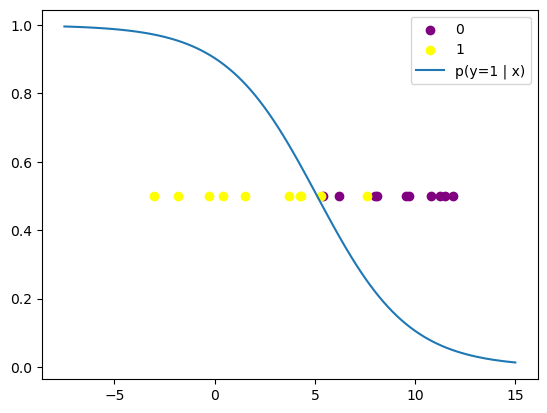

In [41]:
logistic_reg = LogisticRegression(1)
logistic_reg.fit(dataset_1d.data, dataset_1d.target, lr=1e-3, num_steps=int(2e4))
acc = calculate_accuracy(logistic_reg, dataset_1d.data, dataset_1d.target)
print("Accuracy", acc)

plot_dataset_1d(logistic_reg, dataset_1d)

Accuracy 0.99


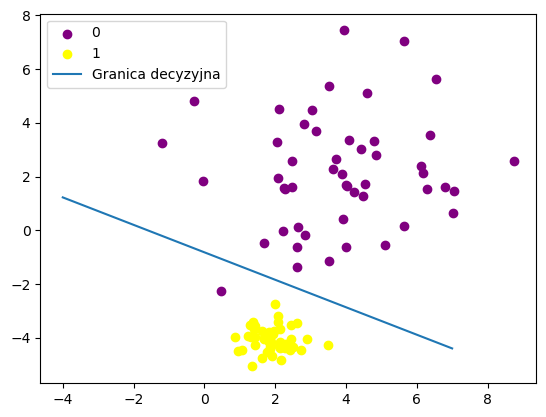

In [43]:
logistic_reg = LogisticRegression(2)
logistic_reg.fit(dataset_2d.data, dataset_2d.target, lr=1e-2, num_steps=int(2e4))
acc = calculate_accuracy(logistic_reg, dataset_2d.data, dataset_2d.target)
print("Accuracy", acc)

plot_dataset_2d(logistic_reg, dataset_2d)

# Część 2: Reguła łańcuchowa i automatyczne różniczkowanie

Przypomnijmy sobie regułę łańcuchową liczenia pochodnych. Jeśli mamy:
$$ L(x) = g(f(x)), $$ 
to wtedy:

$$ \frac{dL(x)}{dx} = \frac{dL(x)}{df(x)}\frac{df(x)}{dx} $$

W kontekście automatycznego różniczkowania w PyTorchu kluczowa jest tu właściwość, że do policzenia gradientu nie musimy nic wiedzieć o $g(x)$ o ile tylko znamy $\frac{dL(x)}{df(x)}$. **Każdy moduł wie, jak policzyć swój gradient i dzięki temu można łańcuchowo liczyć pochodne skomplikowanych funkcji.**


W PyTorchu każda funkcja, której używamy, ma zaimplementowane dwa podmoduły:
* **Forward** - na podstawie podanego $x$ potrafi obliczyć $f(x)$. 
* **Backward** - na podstawie podanego $\frac{dL(x)}{df(x)}$ potrafi policzyć $\frac{dL(x)}{dx}$.

Więcej o automatycznym różniczkowaniu można przeczytać w [dokumentacji PyTorcha](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

In [45]:
# Przygotujmy sobie dane do testów
input = torch.randn(30, 20, dtype=torch.double, requires_grad=True) * 3
a = torch.randn(20, 30, requires_grad=True).double() * 2 - 5
b = torch.randn(20, 30, requires_grad=True).double() + 6


preds = torch.rand(30, requires_grad=True).double()
labels_dist = torch.distributions.Bernoulli(probs=0.7)
labels = labels_dist.sample([30]).double()

## Przykład: różniczkowanie mnożenia
Chcemy zaimplementować od nowa w PyTorchu fukcję $f(a, b) = a \cdot b$, która potrafi policzyć swoje pochodne.

W efekcie implementujemy obiekt typu `torch.autograd.Function` z metodami:
* **Forward** 
    1. Dostaje na wejściu `a` oraz `b`
    1. Zapamiętuje `a` oraz `b`, które przydadzą się później przy liczeniu pochodnej
    2. Zwraca `a * b`
* **Backward**
    1. Dostaje na wejściu `grad_output` reprezentujące wartość $\frac{dL(x)}{df(a, b)}$.
    2. Wyjmuje z pamięci `a` oraz `b`.
    3. Liczy swoją pochodną po a: $\frac{df(a, b)}{da} = \frac{da}{da} \cdot b + a \cdot \frac{db}{da} = 1\cdot b + a\cdot 0 = b$
    4. Liczy swoją pochodną po b: $\frac{df(a, b)}{db} = \frac{da}{db} \cdot b + a \cdot \frac{db}{db} = 0\cdot b + a\cdot 1 = a$
    5. Zwraca pochodne $\frac{dL(x)}{df(a, b)} \frac{df(a, b)}{da}$ oraz $\frac{dL(x)}{df(a, b)} \frac{df(a, b)}{db}$.

In [53]:
class MyProduct(torch.autograd.Function):  # type: ignore
    @staticmethod
    def forward(self, a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:  # type: ignore
        self.save_for_backward(a, b)
        return a * b

    @staticmethod
    def backward(self, grad_output: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:  # type: ignore
        # Wyjmujemy z pamięci a oraz b
        a, b = self.saved_tensors
        # Liczymy pochodną po a
        a_grad = b
        # Liczymy pochodną po b
        b_grad = a

        # Zwracamy "łańcuchowe" pochodne
        return grad_output * a_grad, grad_output * b_grad


prod_fn = MyProduct.apply
torch.autograd.gradcheck(prod_fn, (a, b), eps=1e-3, atol=1e-2, rtol=1e-2)

True

## Zadanie 3 (3 pkt.)
Proszę zaimplementować backward pass w następujących funkcjach:
* MyAdd(a, b): a + b - $\frac{df}{da} = 1, \frac{df}{db} = 1$
* MyDiv(a, b): a / b - $\frac{df}{da} = \frac{1}{b}, \frac{df}{db}= -\frac{a}{b^2}$
* MySigmoid(input): tak jak w zadaniu 2  - $\frac{df}{dz} = \sigma(z)(1 - \sigma(z)) = \frac{1}{1 + \exp(-z)} \cdot (1 - \frac{1}{1 + \exp(-z))})$
* BCE(preds, labels): tak jak w zadaniu 2 - $\frac{df}{d\hat{y}} = \frac{1}{N} (-\frac{y}{\hat{y}} + \frac{1 - y}{1 - \hat{y}}),$ gdzie $y$ to etykieta a $\hat{y}$ to predykcja.

(jako że nie liczymy tutaj pochodnej po etykietach, można zwrócić `grad_labels = None`)

**Zdarza się, że funkcja do testowania gradientu `torch.autograd.gradcheck` będzie wyrzucała błędy przez niedokładności numeryczne. Proszę odświeżyć dane i spróbować jeszcze raz.**

In [57]:
class MyAdd(torch.autograd.Function):  # type: ignore
    @staticmethod
    def forward(self, a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:  # type: ignore
        self.save_for_backward(a, b)
        return a + b

    @staticmethod
    def backward(self, grad_output: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:  # type: ignore
        a, b = self.saved_tensors
        return grad_output, grad_output


add_fn = MyAdd.apply
torch.autograd.gradcheck(add_fn, (a, b), eps=1e-3, atol=1e-2, rtol=1e-2)

True

In [63]:
class MyDiv(torch.autograd.Function):  # type: ignore
    @staticmethod
    def forward(self, a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:  # type: ignore
        self.save_for_backward(a, b)
        return a / b

    @staticmethod
    def backward(self, grad_output: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:  # type: ignore
        a, b = self.saved_tensors
        grad_a = grad_output / b
        grad_b = grad_output * (-a / (b * b))
        return grad_a, grad_b


div_fn = MyDiv.apply
torch.autograd.gradcheck(div_fn, (a, b), eps=1e-3, atol=1e-2, rtol=1e-2)

True

In [65]:
class MySigmoid(torch.autograd.Function):  # type: ignore
    @staticmethod
    def forward(self, input_: torch.Tensor) -> torch.Tensor:  # type: ignore
        self.save_for_backward(input_)
        return 1.0 / (1.0 + torch.exp(-input_))


    @staticmethod
    def backward(self, grad_output: torch.Tensor) -> torch.TensorType:  # type: ignore
        (input_,) = self.saved_tensors
        s = 1.0 / (1.0 + torch.exp(-input_))
        grad_input = grad_output * s * (1.0 - s)
        return grad_input


sigmoid_fn = MySigmoid.apply
torch.autograd.gradcheck(sigmoid_fn, input)

True

In [67]:
class MyBinaryCrossEntropy(torch.autograd.Function):  # type: ignore
    @staticmethod
    def forward(
        self, preds: torch.Tensor, labels: torch.Tensor, bias: torch.Tensor | None = None  # type: ignore
    ) -> torch.Tensor:
        self.save_for_backward(preds, labels)
        eps = 1e-10  # by uniknąć log(0)
        # BCE = -mean(y log(pred) + (1-y) log(1 - pred))
        bce = -torch.mean(
            labels * torch.log(preds + eps) +
            (1 - labels) * torch.log(1.0 - preds + eps)
        )
        return bce

    @staticmethod
    def backward(self, grad_output: torch.Tensor) -> torch.Tensor:  # type: ignore
        preds, labels = self.saved_tensors
        eps = 1e-10
        N = preds.shape[0]

        # d/d(pred) BCE = - [ y/pred - (1-y)/(1-pred) ] / N
        #                = (1/N) * [ - y/pred + (1-y)/(1-pred) ]
        grad_preds = (-labels / (preds + eps) + (1 - labels) / (1 - preds + eps)) / N
        # Mnożymy przez grad_output (łańcuchowo)
        grad_preds = grad_output * grad_preds

        grad_labels = None  # nie liczymy pochodnej po y
        return grad_preds, grad_labels


bce_fn = MyBinaryCrossEntropy.apply
torch.autograd.gradcheck(bce_fn, (preds, labels), eps=1e-3, atol=1e-2, rtol=1e-1)

True

Sprawdźmy nasze moduły w prostej pętli treningowej:

In [69]:
# Przygotowujemy prosty dataset
X = torch.cat([torch.randn(10) * 3 + 2, torch.randn(10) * 3 + 12])
y = torch.cat([torch.zeros(10), torch.ones(10)])


# Inicjalizujemy zmienne
weight = torch.randn((), requires_grad=True)
bias = torch.randn((), requires_grad=True)

lr = 1e-1
for idx in range(10000):
    weight.requires_grad = True
    bias.requires_grad = True

    # Liczymy funkcję kosztu za pomocą naszych modułów
    logit = add_fn(prod_fn(weight, X), bias)
    pred = sigmoid_fn(logit)
    loss = bce_fn(pred, y)

    # Gradient przechodzi przez funkcję backward każdego modułu
    loss.backward()

    # Wyciągamy gradienty
    w_grad = weight.grad
    b_grad = bias.grad

    # Wykonujemy krok metody spadku gradientu
    with torch.no_grad():
        weight = weight - lr * w_grad
        bias = bias - lr * b_grad

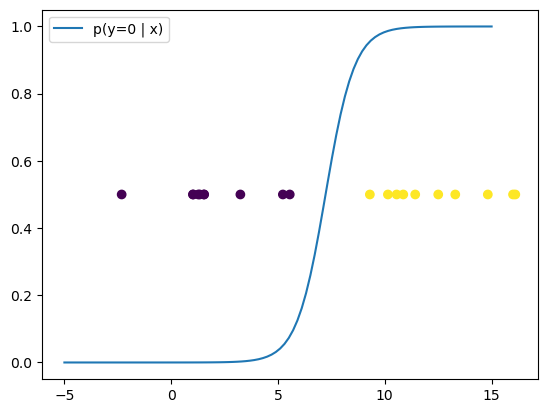

In [71]:
plt.scatter(X, np.zeros_like(X) + 0.5, c=y.numpy())

linspace = torch.linspace(-5, 15, steps=100).view(-1, 1)
with torch.no_grad():
    plt.plot(
        linspace.numpy().ravel(),
        sigmoid_fn(add_fn(prod_fn(weight, linspace), bias)).detach().numpy(),
        label="p(y=0 | x)",
    )
    plt.legend()

## Dygresje
* Istnieją inne frameworki do deep learningu poza PyTorchem. Szczególnie popularny jest teraz TensorFlow (często używany razem z Kerasem). Popularne w przeszłości, ale wciąż poniekąd istotne są: Theano, Caffe, MXNet, Jax.
* Sigmoid staje się bardziej naturalny, kiedy myślimy o outputach z modelu liniowego jako o logarytmie szans (*log-odds* albo *logits*). [Więcej tutaj](https://en.wikipedia.org/wiki/Logistic_regression#Logistic_model). 